In [10]:
from matplotlib.pyplot import imread

# -*- coding: utf-8 -*-
"""
Created on Saturday Nov 15 15:34 2025

@author: 100yearsahead


Bleaching Presence Detection
Target variable: Percent_Bleaching

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os


path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

# Removed only locations and labels, no real data touched
# df.drop("Ocean_Name", axis=1, inplace=True)
# df.drop("Country_Name", axis=1, inplace=True)
# df.drop("Sample_ID", axis=1, inplace=True)
# df.drop("Date_Year", axis=1, inplace=True)
# df.drop("Bleaching_Level", axis=1, inplace=True)
# df.drop("Realm_Name", axis=1, inplace=True)
# # #Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# # # For the sake of bigger dataset this feature is dropped
# df.drop("Percent_Cover", axis=1, inplace=True)
# # df.drop("ClimSST", inplace=True, axis=1)
# df.drop("Exposure", inplace=True, axis=1)
# # df.drop("Temperature_Maximum", inplace=True, axis=1)

# label_encoder = LabelEncoder()
# df["Exposure"] = label_encoder.fit_transform(df["Exposure"])

# These features were taken into account that data is nonlinear
# df = df[["Distance_to_Shore", "Temperature_Mean", "Turbidity", "TSA", "Depth_m", "Percent_Bleaching"]]

# These features were taken into account that data is linear
#df = df[['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Bleaching']]

df.dropna(inplace=True)
df  = df.drop(columns=['Sample_ID'])
df.info()
print(df)


<class 'pandas.core.frame.DataFrame'>
Index: 22561 entries, 6981 to 35042
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    22561 non-null  float64
 1   Depth_m              22561 non-null  float64
 2   ClimSST              22561 non-null  float64
 3   Ocean_Name           22561 non-null  object 
 4   Country_Name         22561 non-null  object 
 5   Distance_to_Shore    22561 non-null  float64
 6   Exposure             22561 non-null  object 
 7   Turbidity            22561 non-null  float64
 8   Date_Year            22561 non-null  int64  
 9   Bleaching_Level      22561 non-null  object 
 10  Temperature_Maximum  22561 non-null  float64
 11  SSTA                 22561 non-null  float64
 12  TSA                  22561 non-null  float64
 13  Percent_Bleaching    22561 non-null  float64
 14  Temperature_Mean     22561 non-null  float64
 15  Realm_Name           22561 non-null  o

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Split first (no leakage)
X = df.drop(columns=['Percent_Bleaching'])
y = df['Percent_Bleaching']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Since we have categorical variables we need to seperate the numeric and the categorical variables 
cat_cols = ['Realm_Name','Ocean_Name','Country_Name','Exposure','Bleaching_Level']
num_cols = [col for col in X.columns if col not in cat_cols]



# We one_hot_encode the categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])


# We scale the numeric features
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])


# Combine the categorical and numerical features
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed  = np.hstack([X_test_num, X_test_cat])

print(ohe.categories_)
print(X_train_processed.mean())
print(X_train_processed.std())
print(np.sum(X_train_processed))




[array(['Central Indo-Pacific', 'Eastern Indo-Pacific',
       'Temperate Australasia', 'Temperate Northern Pacific',
       'Tropical Atlantic', 'Tropical Eastern Pacific',
       'Western Indo-Pacific'], dtype=object), array(['Arabian Gulf', 'Atlantic', 'Indian', 'Pacific', 'Red Sea'],
      dtype=object), array(['Antigua and Barbuda', 'Australia', 'Bahamas', 'Bangladesh',
       'Barbados', 'Belize', 'Brazil', 'Brunei', 'Cambodia', 'China',
       'Colombia', 'Commonwealth of the Northern Mariana Islands',
       'Cook Islands', 'Costa Rica', 'Cuba', 'Djibouti', 'Dominica',
       'Dominican Republic', 'East Timor', 'Egypt',
       'Federated States of Micronesia', 'Fiji', 'France',
       'French Polynesia', 'Grenada', 'Guatemala', 'Haiti', 'Honduras',
       'India', 'Indonesia', 'Iran', 'Jamaica', 'Japan', 'Jordan',
       'Kenya', 'Kiribati', 'Kuwait', 'Madagascar', 'Malaysia',
       'Maldives', 'Marshall Islands', 'Martinique', 'Mauritius',
       'Mexico', 'Montserrat', 'Moza

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Add
)
from tensorflow.keras.callbacks import EarlyStopping


def build_mlp(input_dim):

    nodes_number = int((input_dim + 1) * 2/3)

    inputs = Input(shape=(input_dim,))
    x = Dense(nodes_number, activation='relu')(inputs)
    x = Dense(nodes_number, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
        loss='mse',
        metrics=['mae']
    )

    return model

In [28]:
input_dim = X_train_processed.shape[1]
model = build_mlp(input_dim)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 70)             │         7,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 70)             │         4,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,391 (48.40 KB)

 Trainable params: 12,391 (48.40 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:

# Stops training when the model stops improving prevents overfitting
early_stop = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='loss'
)

history = model.fit(
    X_train_processed,
    y_train,
    validation_split=0.05,   # 20% of training becomes validation
    epochs=200,
    #batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/200
536/536 - 1s - 2ms/step - loss: 90.1856 - mae: 4.0465 - val_loss: 74.4735 - val_mae: 3.7842
Epoch 2/200
536/536 - 0s - 749us/step - loss: 73.1683 - mae: 3.5865 - val_loss: 73.3592 - val_mae: 3.3218
Epoch 3/200
536/536 - 0s - 749us/step - loss: 69.8583 - mae: 3.5009 - val_loss: 69.3422 - val_mae: 3.3463
Epoch 4/200
536/536 - 0s - 767us/step - loss: 67.0576 - mae: 3.4169 - val_loss: 68.4066 - val_mae: 3.8459
Epoch 5/200
536/536 - 0s - 757us/step - loss: 64.6037 - mae: 3.3592 - val_loss: 66.1453 - val_mae: 3.5886
Epoch 6/200
536/536 - 0s - 815us/step - loss: 62.7062 - mae: 3.3011 - val_loss: 65.9392 - val_mae: 3.3193
Epoch 7/200
536/536 - 0s - 819us/step - loss: 60.8000 - mae: 3.2342 - val_loss: 65.0164 - val_mae: 3.3353
Epoch 8/200
536/536 - 0s - 862us/step - loss: 58.3556 - mae: 3.1846 - val_loss: 67.1496 - val_mae: 3.4501
Epoch 9/200
536/536 - 0s - 888us/step - loss: 57.1582 - mae: 3.1612 - val_loss: 62.0208 - val_mae: 3.4765
Epoch 10/200
536/536 - 0s - 911us/step - loss: 5

In [30]:
test_loss, test_mae = model.evaluate(X_test_processed, y_test, verbose=0)

print("Test MSE:", test_loss)
print("Test MAE:", test_mae)

Test MSE: 38.911739349365234
Test MAE: 2.4198672771453857


In [31]:
y_pred = model.predict(X_test_processed)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
MSE: 38.9117374034473
RMSE: 6.237927332331413
MAE: 2.4198673087811486
R²: 0.6691377737007123


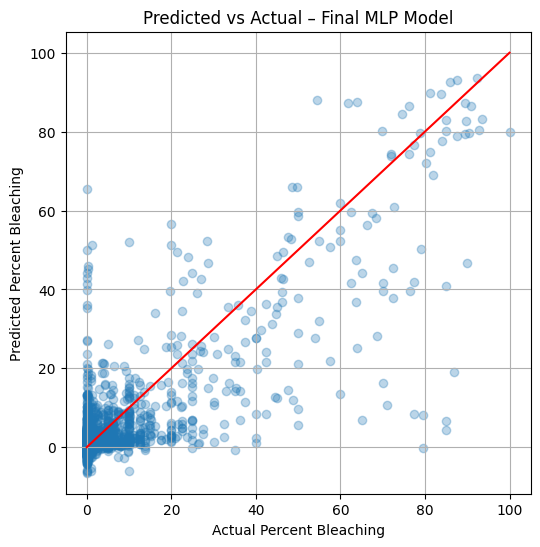

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0,100], [0,100], color='red')  # diagonal reference
plt.xlabel("Actual Percent Bleaching")
plt.ylabel("Predicted Percent Bleaching")
plt.title("Predicted vs Actual – Final MLP Model")
plt.grid(True)
plt.show()